In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [19]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Wed Feb 28 20:03:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              N/A / ERR! |   1142MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
# num_heads = 1

# alpha_list = [10] # stiffness parameter
# A_list = [torch.tensor([[0., -1.], [1., 2*i]], device=dev).double() for i in alpha_list]
# force_list = [torch.tensor([[0.], [0.]], device=dev).double() for _ in range(num_heads)]
# IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

# def random_IC(x_bound=[0, 5], y_bound=[0, 2]):
#     ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
#     ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
#     return torch.tensor([ICx, ICy], device=dev).double()
# #IC_list = [random_IC() for i in range(num_heads)]

# def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
#     force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
#     force2 = np.random.uniform(force2_bound[0], force2_bound[1], 1)
#     return torch.tensor([force1, force2], device=dev).double()
# #force_list = [random_force() for i in range(num_heads)]

# equation_name = "DHO"

In [21]:
num_heads = 5

alpha_list = [2, 4, 6, 8, 10] # stiffness parameter
A_list = [torch.tensor([[0., -1.], [1., 2*i]], device=dev).double() for i in alpha_list]
force_list = [torch.tensor([[0.], [0.]], device=dev).double() for _ in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

def random_IC(x_bound=[0, 5], y_bound=[0, 5]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev).double()
#IC_list = [random_IC() for i in range(num_heads)]

def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev).double()
#force_list = [random_force() for i in range(num_heads)]

equation_name = "DHO"

In [22]:
x_range = [0, 10]
activation = "silu"
hid_lay = list(np.array([124, 124, 132]) * 1)
num_equations = 2
iterations = 20000

In [23]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

In [24]:
sample_factor = 1
lr = 0.0001
verbose = True

sample_size = 512
decay=True


loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr, A_list=A_list, 
                                                  v_list=IC_list, force=force_list, hid_lay=hid_lay, activation=activation,
                                                  num_equations=num_equations, num_heads=num_heads, sample_size=sample_size,
                                                  decay=decay, dev=dev, verbose=verbose)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/20000 [00:00<?, ?it/s]

Iterations 0, L_total = 3.92404552808539, L_ODE = 3.294344476594104, L_IC = 0.6297010514912863


KeyboardInterrupt: 

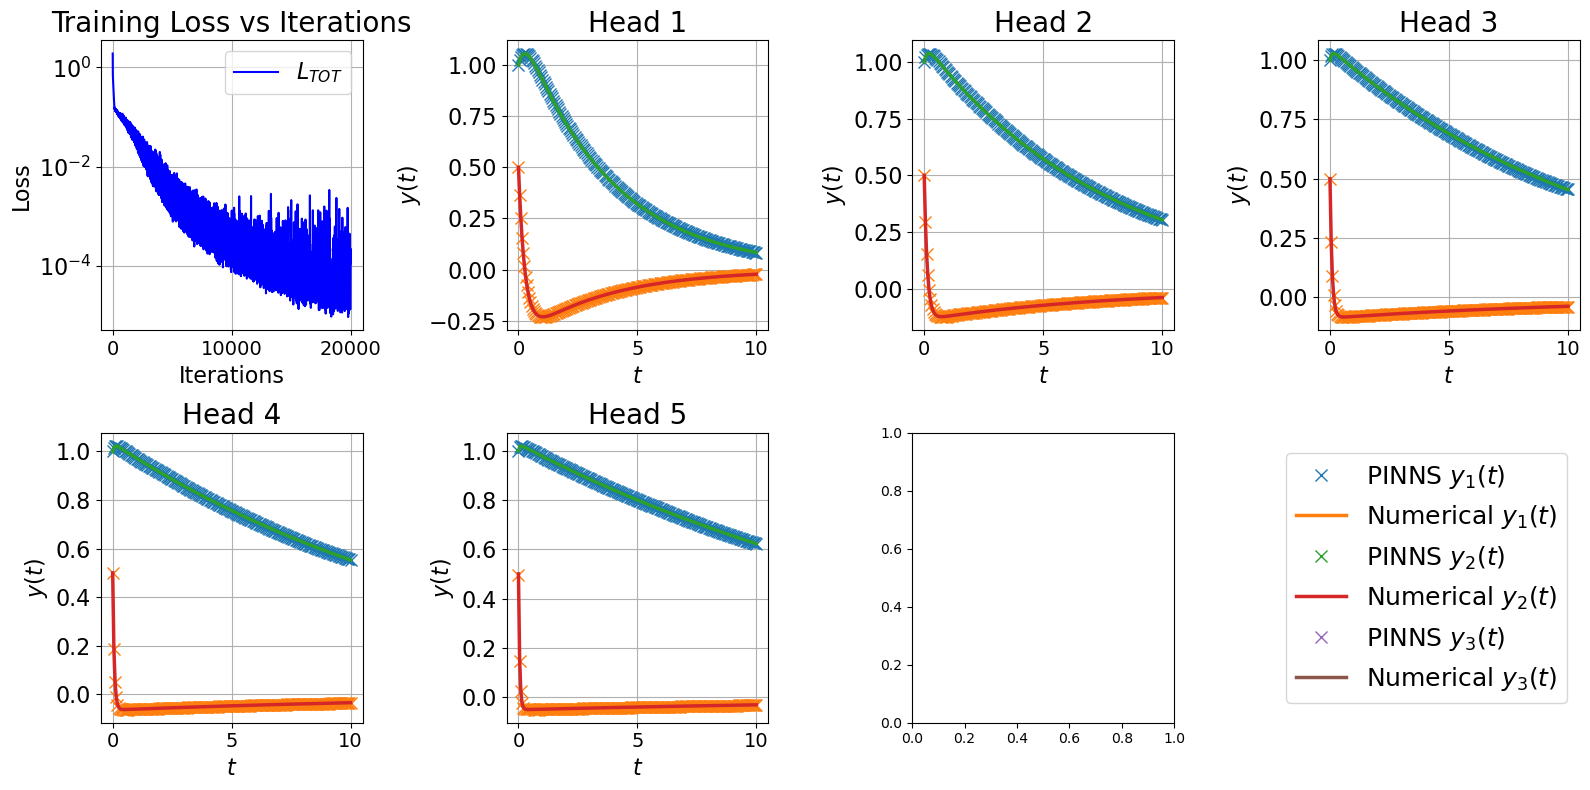

In [10]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist, device=dev)

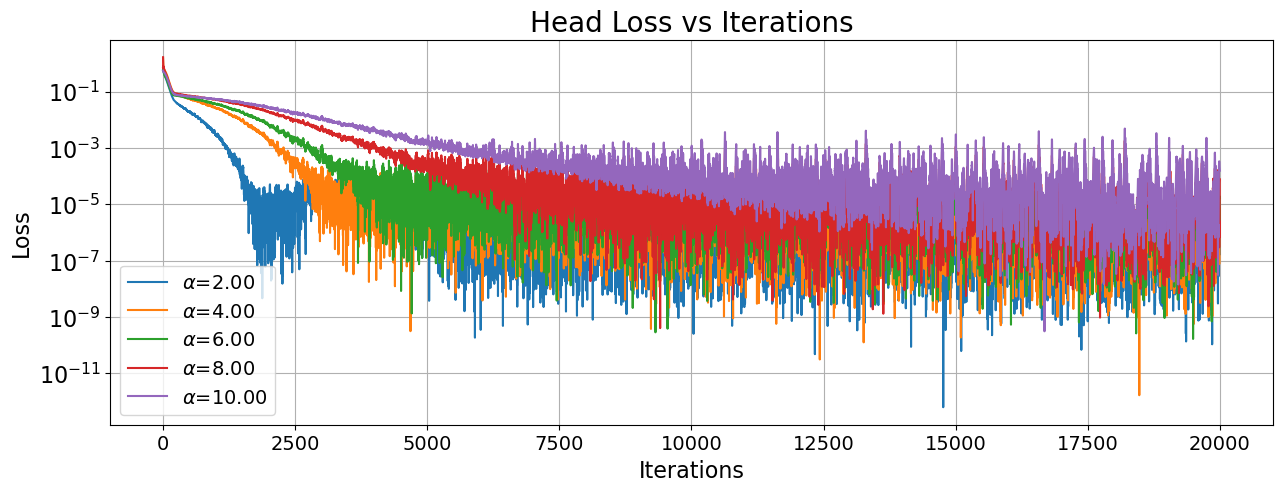

In [15]:
plot_head_loss(loss_hist["head"], alpha_list)   

In [16]:
model_name = "final_new"

save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/DHO/history_final_new_2281727.json


# multi single training

In [27]:
from tqdm.auto import trange


num_heads = 1
alpha_list = [5, 10, 15, 20, 25]
A_list = [torch.tensor([[0., -1.], [1., 2*i]], device=dev).double() for i in alpha_list]
lr_list = [0.0001, 0.0001, 0.00003, 0.00001, 0.000003]
iterations_list = [20000, 20000, 30000, 40000, 60000]
solution_PINNS = []

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
t_eval = t_eval[np.concatenate(([0], rng.choice(range(1, len(t_eval)), size=512 - 1, replace=False)))]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)

for i in trange(len(alpha_list)):
    _, trained_model, _ = run_model_new(iterations=iterations_list[i], x_range=x_range, lr=lr_list[i], A_list=[A_list[i]], 
                                        v_list=[IC_list[0]], force=[force_list[0]], hid_lay=hid_lay, activation=activation,
                                        num_equations=num_equations, num_heads=num_heads, sample_size=sample_size,
                                        decay=decay, dev=dev, verbose=verbose)
    solution_PINNS.append(trained_model(t_eval)[0])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Iterations 0, L_total = 2.017342899195236, L_ODE = 1.4562215377609624, L_IC = 0.5611213614342736
Iterations 100, L_total = 0.13458402961564908, L_ODE = 0.016473713129942735, L_IC = 0.11811031648570634
Iterations 200, L_total = 0.12506230489232442, L_ODE = 0.023638198842222433, L_IC = 0.10142410605010198
Iterations 300, L_total = 0.12368087926699244, L_ODE = 0.02835304330328532, L_IC = 0.09532783596370711
Iterations 400, L_total = 0.11391504996135779, L_ODE = 0.028558894011245013, L_IC = 0.08535615595011278
Iterations 500, L_total = 0.10494633099005202, L_ODE = 0.029034016739327848, L_IC = 0.07591231425072417
Iterations 600, L_total = 0.10648459514897374, L_ODE = 0.035154430698562535, L_IC = 0.07133016445041121
Iterations 700, L_total = 0.09338520803210475, L_ODE = 0.03229071807252966, L_IC = 0.06109448995957509
Iterations 800, L_total = 0.1040880354725966, L_ODE = 0.045205433611270024, L_IC = 0.058882601861326565
Iterations 900, L_total = 0.07556156110053978, L_ODE = 0.0277984324668140

  0%|          | 0/20000 [00:00<?, ?it/s]

Iterations 0, L_total = 22.827977376670805, L_ODE = 22.251662374109138, L_IC = 0.5763150025616681
Iterations 100, L_total = 0.38295014674646566, L_ODE = 0.008180467985471552, L_IC = 0.3747696787609941
Iterations 200, L_total = 0.20418070053889656, L_ODE = 0.012930731466956743, L_IC = 0.1912499690719398
Iterations 300, L_total = 0.14910064657337682, L_ODE = 0.017002222098584475, L_IC = 0.13209842447479234
Iterations 400, L_total = 0.14372509319184484, L_ODE = 0.019231158582221977, L_IC = 0.12449393460962285
Iterations 500, L_total = 0.13761026102442983, L_ODE = 0.014559674718924054, L_IC = 0.12305058630550578
Iterations 600, L_total = 0.13989354374135773, L_ODE = 0.017093111613496144, L_IC = 0.1228004321278616
Iterations 700, L_total = 0.13538392013742134, L_ODE = 0.013445909179650314, L_IC = 0.12193801095777103
Iterations 800, L_total = 0.13623767672101456, L_ODE = 0.014387684897627371, L_IC = 0.12184999182338718
Iterations 900, L_total = 0.1374777170301081, L_ODE = 0.01638773826282827

  0%|          | 0/30000 [00:00<?, ?it/s]

Iterations 0, L_total = 0.6540527511956759, L_ODE = 0.16090768905235778, L_IC = 0.4931450621433181
Iterations 100, L_total = 0.24075306271601207, L_ODE = 0.004566146869024756, L_IC = 0.2361869158469873
Iterations 200, L_total = 0.1474125935287109, L_ODE = 0.007710346192644391, L_IC = 0.1397022473360665
Iterations 300, L_total = 0.13405101855598442, L_ODE = 0.0064359965783335705, L_IC = 0.12761502197765084
Iterations 400, L_total = 0.13211204304034302, L_ODE = 0.00568964764427086, L_IC = 0.12642239539607217
Iterations 500, L_total = 0.13184346161706387, L_ODE = 0.006107744327158509, L_IC = 0.12573571728990535
Iterations 600, L_total = 0.1325311438793813, L_ODE = 0.007305217147743029, L_IC = 0.1252259267316383
Iterations 700, L_total = 0.13075194251626002, L_ODE = 0.005792586338662758, L_IC = 0.12495935617759725
Iterations 800, L_total = 0.132247696720527, L_ODE = 0.007917132993103693, L_IC = 0.1243305637274233
Iterations 900, L_total = 0.13054299759354956, L_ODE = 0.008473141682190004, 

  0%|          | 0/40000 [00:00<?, ?it/s]

Iterations 0, L_total = 8.255772235399204, L_ODE = 7.7241766164313646, L_IC = 0.5315956189678404
Iterations 100, L_total = 0.7075458092162318, L_ODE = 0.18096004223248385, L_IC = 0.5265857669837479
Iterations 200, L_total = 0.5859561352996685, L_ODE = 0.08668372963863279, L_IC = 0.49927240566103576
Iterations 300, L_total = 0.5080587399848988, L_ODE = 0.04443226596898414, L_IC = 0.4636264740159146
Iterations 400, L_total = 0.45804414621535194, L_ODE = 0.03070153271579834, L_IC = 0.4273426134995536
Iterations 500, L_total = 0.41824507406179046, L_ODE = 0.026988802748641766, L_IC = 0.3912562713131487
Iterations 600, L_total = 0.3746570920261772, L_ODE = 0.01823263410468671, L_IC = 0.35642445792149047
Iterations 700, L_total = 0.3408883303464755, L_ODE = 0.017502478703399917, L_IC = 0.32338585164307554
Iterations 800, L_total = 0.3062401697694088, L_ODE = 0.013269417376551344, L_IC = 0.29297075239285747
Iterations 900, L_total = 0.2774779355861751, L_ODE = 0.011717501245131347, L_IC = 0.2

  0%|          | 0/60000 [00:00<?, ?it/s]

Iterations 0, L_total = 1.0850566702969644, L_ODE = 0.5803265881257671, L_IC = 0.5047300821711973
Iterations 100, L_total = 0.5578068471413486, L_ODE = 0.04797688756946657, L_IC = 0.509829959571882
Iterations 200, L_total = 0.5102383065066203, L_ODE = 0.019783951916730918, L_IC = 0.4904543545898894
Iterations 300, L_total = 0.4769743714623104, L_ODE = 0.011507613065030193, L_IC = 0.46546675839728024
Iterations 400, L_total = 0.44656708701864806, L_ODE = 0.00763951713300632, L_IC = 0.43892756988564174
Iterations 500, L_total = 0.4177705565660977, L_ODE = 0.005875031279868931, L_IC = 0.41189552528622875
Iterations 600, L_total = 0.38970887103252144, L_ODE = 0.00438203437371438, L_IC = 0.38532683665880707
Iterations 700, L_total = 0.3634418522004833, L_ODE = 0.0037069184652159456, L_IC = 0.3597349337352674
Iterations 800, L_total = 0.3386244492812745, L_ODE = 0.00338893259627988, L_IC = 0.3352355166849946
Iterations 900, L_total = 0.315385902937303, L_ODE = 0.0032194132362712083, L_IC = 0

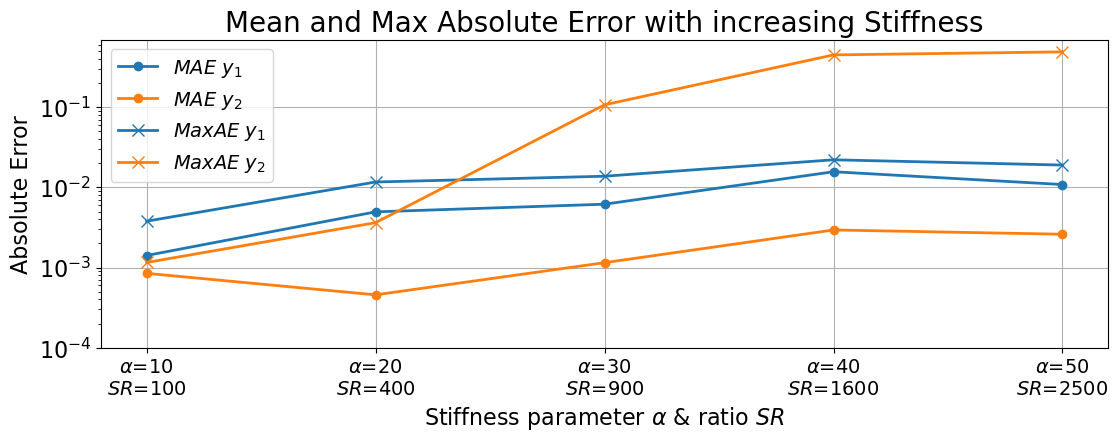

In [29]:
mae_y1 = []
mae_y2 = []
maxae_y1 = []
maxae_y2 = []

for i in range(len(alpha_list)):
    pinns = solution_PINNS[i].detach().cpu().numpy()
    numerical = numerical_sol_fct(t_eval.detach().cpu().numpy(),
                                  IC_list[0].detach().cpu().numpy(),
                                  A_list[i].detach().cpu().numpy(),
                                  force_list[0]).T
    absolute_error = np.abs(pinns[:, 0, :] - numerical)
    mae_y1.append(absolute_error.mean(0)[0])
    mae_y2.append(absolute_error.mean(0)[1])
    maxae_y1.append(absolute_error.max(0)[0])
    maxae_y2.append(absolute_error.max(0)[1])

fig, ax = plt.subplots(1, figsize=(13, 4))

ax.plot(alpha_list, mae_y1, "-o", label="$MAE$ ${y_1}$", linewidth=2, markersize=6)
ax.plot(alpha_list, mae_y2,"-o", label="$MAE$ ${y_2}$", linewidth=2, markersize=6)
ax.plot(alpha_list, maxae_y1, "-x", color="#1f77b4", label="$MaxAE$ ${y_1}$", linewidth=2, markersize=8)
ax.plot(alpha_list, maxae_y2, "-x", color="#ff7f0e", label="$MaxAE$ ${y_2}$", linewidth=2, markersize=8)

ax.set_yscale("log")
ax.set_title(r"Mean and Max Absolute Error with increasing Stiffness", fontsize=20)
ax.set_xlabel(r'Stiffness parameter $\alpha$ & ratio $SR$', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=16)
ax.set_xticks(alpha_list, [r"$\alpha$=" + str(2*i) + "\n" +rf"$SR$={4*i**2}" for i in alpha_list])
ax.set_yticks([0.1, 0.01, 0.001, 0.0001],
              [r"$10^{-1}$", r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"])
ax.grid()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=14)

In [32]:
40**2

1600

In [30]:
import json

history = {}
history["alpha_list"] = alpha_list
history["mae_y1"] = mae_y1
history["mae_y2"] = mae_y2
history["maxae_y1"] = maxae_y1
history["maxae_y2"] = maxae_y2

with open(r"D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\result_history\DHO_Error_Trained.json",  "w") as fp:
    json.dump(history, fp)